# Evaluación de Datos Climáticos

## Introducción
Este trabajo tiene como objetivo analizar los datos climáticos de la ciudad de Sydney para predecir la probabilidad de lluvia al día siguiente. Este análisis sigue el modelo CRISP-DM, centrándose en las fases de **Business Understanding**, **Data Understanding**, y **Data Preparation**.

## Business Understanding
El objetivo es desarrollar un modelo predictivo para la lluvia en Sydney, lo que ayudará a mejorar la planificación y la seguridad en diversas actividades dependientes del clima.

## Data Understanding
Exploraremos y preprocesaremos los datos climáticos, identificando las características más relevantes y tratando los datos atípicos.


Importación de Bibliotecas

In [ ]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

Carga y Visualización Inicial de Datos

In [ ]:
# Cargar datos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')
drive_content = os.listdir('/content/drive/MyDrive/')
# Cargar los datos
drive_path = '/content/drive/MyDrive/'
# Ruta completa al archivo Excel en Google Drive
file_path = drive_path + '/&>y,'OIL8I Cargar el archivo Excel en un DataFrame
data_frame = pd.read_csv(file_path, delimiter=',',decimal='.')

# Mostrar las primeras filas del DataFrame
data_frame.head()

# Inspección inicial de datos
print(data_frame.shape)
print(data_frame.info())
print(data_frame.describe(include='all'))
print(data_frame.isnull().sum())


Mounted at /content/drive
(142193, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  flo

## Selección de Variables Relevantes
Identificamos las variables más relevantes para el análisis.


In [ ]:
# Seleccionar variables relevantes
variables_relevantes = ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall', 'RainTomorrow']
data_frame = data_frame[variables_relevantes]

# Filtrar datos para la ciudad de Sydney
data_city = data_frame[data_frame['Location'] == 'Sydney']
data_city = data_city.drop(columns=['Location'])
print(data_city.head())


             Date  MinTemp  MaxTemp  Temp9am  Temp3pm  Rainfall RainTomorrow
29497  2008-02-01     19.5     22.4     20.7     20.9      15.6          Yes
29498  2008-02-02     19.5     25.6     22.4     24.8       6.0          Yes
29499  2008-02-03     21.6     24.5     23.5     23.0       6.6          Yes
29500  2008-02-04     20.2     22.8     21.4     20.9      18.8          Yes
29501  2008-02-05     19.7     25.7     22.5     25.5      77.4          Yes


## Identificación de Datos Atípicos
Detectamos y visualizamos los datos atípicos en el conjunto de datos.


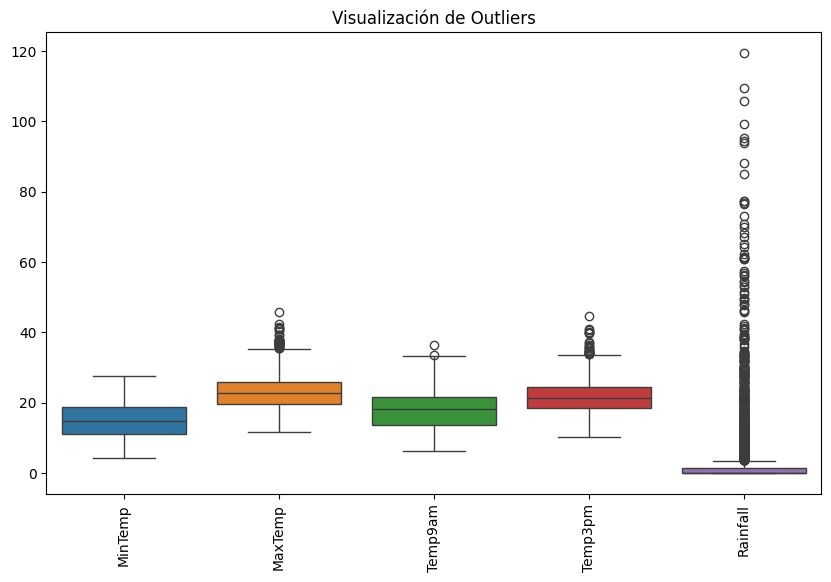

In [ ]:
# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Aplicar a las variables numéricas
outliers = detectar_outliers_iqr(data_city.select_dtypes(include=['float64', 'int64']))

# Visualización de outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_city.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.title('Visualización de Outliers')
plt.show()


## Preparación de Datos
Llenamos los valores faltantes y estandarizamos las variables numéricas.


In [ ]:
# Contar valores nulos por columna en los datos de Sydney
valores_nulos_por_columna = data_city.isnull().sum()
print("Valores nulos antes de la imputación:")
print(valores_nulos_por_columna)

# Rellenar valores faltantes en datos numéricos con la media
columnas_numericas = data_city.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
data_city[columnas_numericas] = imputer.fit_transform(data_city[columnas_numericas])

# Rellenar valores faltantes en datos categóricos con la moda
columnas_categoricas = data_city.select_dtypes(include=[object]).columns
for columna in columnas_categoricas:
    moda = data_city[columna].mode()[0]
    data_city[columna] = data_city[columna].fillna(moda)

# Verificar que no hay valores nulos restantes
valores_nulos_por_columna_despues = data_city.isnull().sum()
print("Valores nulos después de la imputación:")
print(valores_nulos_por_columna_despues)





Valores nulos antes de la imputación:
Date            0
MinTemp         3
MaxTemp         2
Temp9am         4
Temp3pm         4
Rainfall        6
RainTomorrow    0
dtype: int64
Valores nulos después de la imputación:
Date            0
MinTemp         0
MaxTemp         0
Temp9am         0
Temp3pm         0
Rainfall        0
RainTomorrow    0
dtype: int64


Transformación de Variables Categóricas y Numéricas

In [ ]:
from sklearn.model_selection import train_test_split
# Escalar características numéricas
scaler = StandardScaler()
X_escalado_numerico = scaler.fit_transform(data_city[columnas_numericas])

# La variable objetivo para predecir la lluvia mañana
y = data_city['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_escalado_numerico, y, test_size=0.3, random_state=42)


Modelos Supervisados e Interpretación de Resultados

Regresión Lineal para Predicción de lluvia

In [ ]:
# Modelo de Regresión Lineal para Predecir la Lluvia
reg_model = LinearRegression()
X_regresion = X_train
y_regresion = y_train

# Entrenar el modelo de regresión lineal
reg_model.fit(X_regresion, y_regresion)

# Predicciones y evaluación del modelo de regresión lineal
y_reg_pred = reg_model.predict(X_test)
mae = mean_absolute_error(y_test, y_reg_pred)
print(f'Error Absoluto Medio (MAE) de Regresión Lineal: {mae:.2f}')


Error Absoluto Medio (MAE) de Regresión Lineal: 0.33


Modelo Naive Bayes para Predicción de Lluvia

In [ ]:
# Dividir los datos en características (X) y objetivo (y)
X = X_escalado_numerico

# Entrenar el modelo Naive Bayes para predecir la lluvia
model = GaussianNB()
model.fit(X, y)

# Predicciones y evaluación del modelo Naive Bayes
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f'Precisión del modelo Naive Bayes: {accuracy:.2f}')


Precisión del modelo Naive Bayes: 0.77


Modelo de Clustering KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


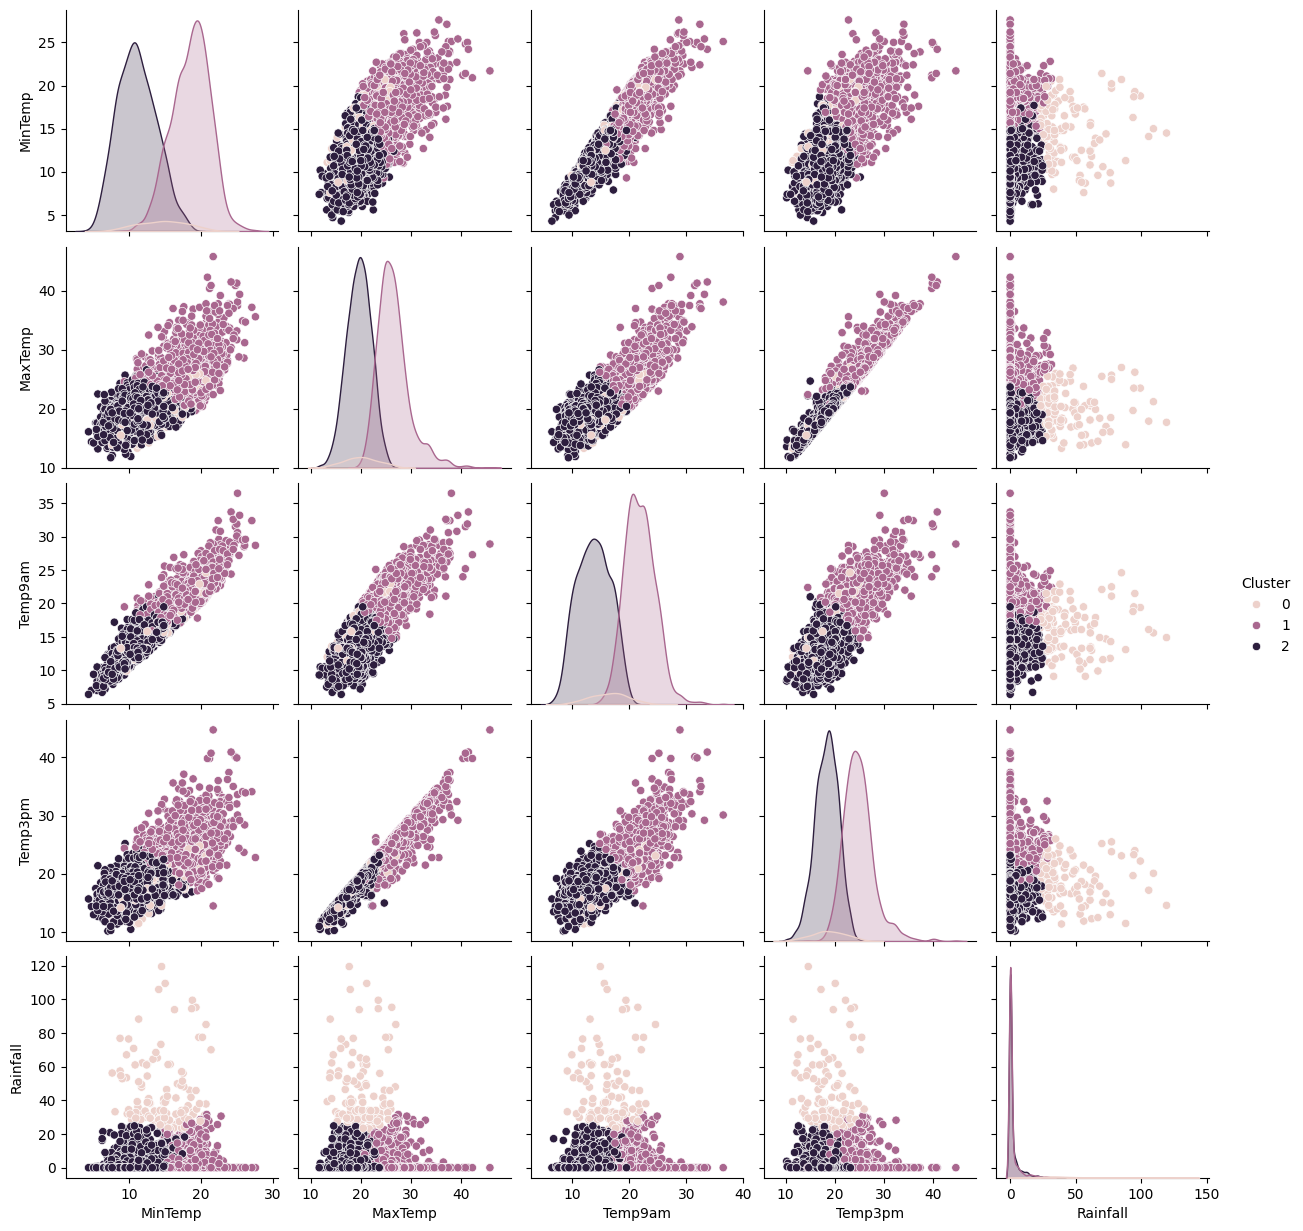

In [ ]:
# Modelo de Clustering KMeans
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X_escalado_numerico)

# Visualización de Clusters
data_city['Cluster'] = kmeans_model.labels_
sns.pairplot(data_city, hue='Cluster', diag_kind='kde')
plt.show()


Preparación del Modelo y Evaluación

In [ ]:
# Dividir los datos en características (X) y objetivo (y)
X = X_escalado_numerico
y = data_city['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

# Entrenar el modelo
model = GaussianNB()
model.fit(X, y)

# Predicciones y evaluación
y_pred = model.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.77


**Conclusión**

En este proyecto, hemos analizado datos climáticos de Sydney para predecir la probabilidad de lluvia al día siguiente y entender mejor las condiciones climáticas. Siguiendo el modelo CRISP-DM, hemos realizado las siguientes etapas:

Identificamos la necesidad de predecir la lluvia para mejorar la planificación y la seguridad en diversas actividades dependientes del clima.

Exploramos el conjunto de datos inicial, seleccionando variables relevantes y verificando la presencia de valores nulos y datos atípicos. Esta etapa fue crucial para asegurar que los datos fueran adecuados para el análisis y el modelado.

**Preparación de los Datos:**

* Manejo de Valores Nulos: Imputamos valores faltantes en las variables numéricas con la media y en las variables categóricas con la moda. Esto nos permitió manejar de manera efectiva los datos incompletos y mejorar la calidad de los datos para el análisis.
* Escalado de Variables: Estandarizamos las variables numéricas para mejorar el rendimiento del modelo, asegurando que todas las variables contribuyeran de manera equitativa al análisis.

**Modelado:**

* Regresión Lineal: Utilizamos regresión lineal para predecir la probabilidad de lluvia al día siguiente basándonos en variables como la temperatura mínima, la temperatura a las 9 am, la temperatura a las 3 pm, y la cantidad de lluvia. La regresión lineal nos ayudó a entender cómo las diferentes variables climáticas afectan la probabilidad de lluvia, proporcionando una visión detallada de las relaciones entre las variables climáticas.
* Naive Bayes: Entrenamos un modelo Naive Bayes para predecir la probabilidad de lluvia al día siguiente. Este modelo es simple y eficaz para problemas de clasificación con variables independientes, y es particularmente útil cuando se necesita obtener resultados rápidos con un conjunto de datos grande.
* Clustering KMeans: Implementamos un modelo de clustering KMeans para identificar patrones en los datos climáticos. Este modelo nos permitió agrupar los datos en clusters, identificando diferentes condiciones climáticas.

**Evaluación:**

* Regresión Lineal: La regresión lineal nos proporcionó una comprensión de cómo las variables climáticas impactan en la probabilidad de lluvia. El Error Absoluto Medio (MAE) nos indicó la efectividad del modelo y cómo las temperaturas a diferentes momentos del día influyen en la probabilidad de lluvia.
* Naive Bayes: El modelo alcanzó una precisión del 77%, indicando que el modelo es razonablemente bueno para predecir la probabilidad de lluvia, aunque hay espacio para mejoras adicionales.
* Clustering KMeans: Nos permitió identificar diferentes perfiles climáticos, representando condiciones climáticas específicas. Estos perfiles pueden ser utilizados para la planificación ayudando a tomar decisiones informadas.



Los resultados obtenidos en este proyecto, como la predicción de la probabilidad de lluvia pueden ser utilizados para desarrollar un índice de estabilidad climática. Este índice puede incorporar la variabilidad de las temperaturas diarias y la presencia de condiciones extremas, proporcionando una herramienta valiosa para la planificación y la gestión de riesgos climáticos.



# ENTREGA 3

En este proyecto, seguiremos el analisis de datos climáticos y predecir la probabilidad de lluvia al día siguiente en la ciudad de Sydney.

El objetivo es preparar los datos y aplicar modelos supervisados y no supervisados para obtener predicciones precisas y útiles.

**Objetivos Específicos**

Preparación de Datos:

- Limpiar y transformar los datos climáticos.

- Manejar valores nulos, estandarizar variables numéricas y codificar variables categóricas.

Implementación de Modelos Supervisados:

- Utilizar al menos dos modelos supervisados (regresión y clasificación) revisados en clases.
- Definir claramente el target objetivo para la predicción de la lluvia.

Implementación de Modelos No Supervisados:

- Incluir al menos un modelo no supervisado para segmentación de datos si los modelos supervisados no alcanzan una métrica de 0.7.

Validación y Comparación de Modelos:

-  Evaluar y comparar los modelos aplicados, seleccionando el mejor según las métricas obtenidas.

Análisis de Resultados:

- Interpretar los resultados obtenidos, proporcionando insights relevantes para apoyar la toma de decisiones.


# Selección de Variables Relevantes

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
# Seleccionar variables relevantes
variables_relevantes = ['Date', 'Location', 'MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall', 'RainTomorrow']
data_frame = data_frame[variables_relevantes]

# Filtrar datos para la ciudad de Sydney
data_city = data_frame[data_frame['Location'] == 'Sydney']
data_city = data_city.drop(columns=['Location'])
print(data_city.head())


             Date  MinTemp  MaxTemp  Temp9am  Temp3pm  Rainfall RainTomorrow
29497  2008-02-01     19.5     22.4     20.7     20.9      15.6          Yes
29498  2008-02-02     19.5     25.6     22.4     24.8       6.0          Yes
29499  2008-02-03     21.6     24.5     23.5     23.0       6.6          Yes
29500  2008-02-04     20.2     22.8     21.4     20.9      18.8          Yes
29501  2008-02-05     19.7     25.7     22.5     25.5      77.4          Yes


# Identificación de Datos Atípicos

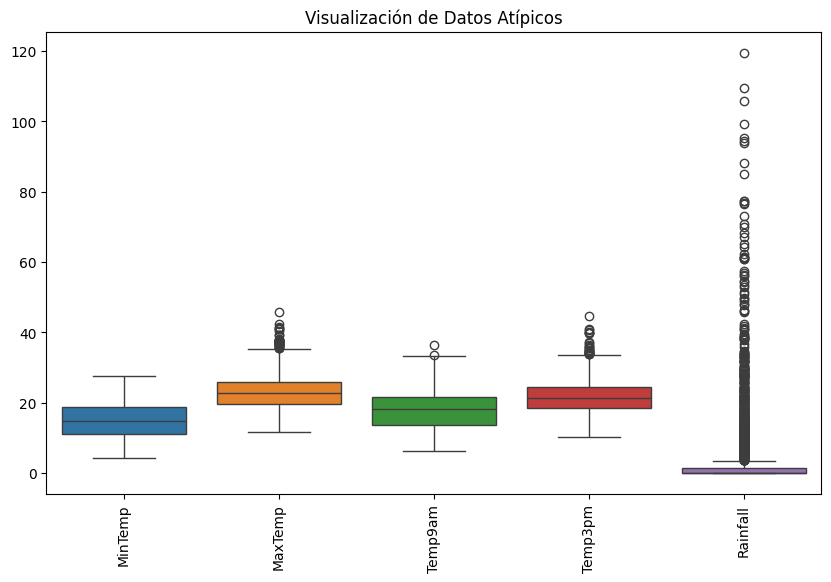

In [ ]:
# Función para detectar outliers usando IQR
def detectar_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Aplicar a las variables numéricas
outliers = detectar_outliers_iqr(data_city.select_dtypes(include=['float64', 'int64']))

# Visualización de outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_city.select_dtypes(include=['float64', 'int64']))
plt.xticks(rotation=90)
plt.title('Visualización de Datos Atípicos')
plt.show()


# Preparación de Datos

In [ ]:
# Contar valores nulos por columna en los datos de Sydney
valores_nulos_por_columna = data_city.isnull().sum()
print(valores_nulos_por_columna)

# Rellenar valores faltantes en datos numéricos con la media
columnas_numericas = data_city.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
data_city[columnas_numericas] = imputer.fit_transform(data_city[columnas_numericas])

# Rellenar valores faltantes en datos categóricos con la moda
columnas_categoricas = data_city.select_dtypes(include=[object]).columns
for columna in columnas_categoricas:
    moda = data_city[columna].mode()[0]
    data_city[columna] = data_city[columna].fillna(moda)

# Verificar que no hay valores nulos restantes
print(data_city.isnull().sum())


Date            0
MinTemp         3
MaxTemp         2
Temp9am         4
Temp3pm         4
Rainfall        6
RainTomorrow    0
dtype: int64
Date            0
MinTemp         0
MaxTemp         0
Temp9am         0
Temp3pm         0
Rainfall        0
RainTomorrow    0
dtype: int64


# Transformación de Variables Categóricas y Numéricas

In [ ]:
# Variables numéricas disponibles en el DataFrame
columnas_numericas = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall']

# Escalar características numéricas
scaler = StandardScaler()
X_escalado_numerico = scaler.fit_transform(data_city[columnas_numericas])

# La variable objetivo para predecir la lluvia mañana
y = data_city['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_escalado_numerico, y, test_size=0.3, random_state=42)


# Comparación de Modelos

- Modelo Naive Bayes

In [ ]:
# Entrenar el modelo Naive Bayes para predecir la lluvia
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Predicciones y evaluación del modelo Naive Bayes
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Precisión del modelo Naive Bayes: {accuracy_nb:.2f}')
print(classification_report(y_test, y_pred_nb))


Precisión del modelo Naive Bayes: 0.76
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       722
           1       0.70      0.23      0.34       280

    accuracy                           0.76      1002
   macro avg       0.73      0.59      0.60      1002
weighted avg       0.74      0.76      0.71      1002



Comparar las métricas entre el conjunto de entrenamiento y el conjunto de prueba

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train = model_nb.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Precisión del modelo Naive Bayes en el conjunto de entrenamiento: {accuracy_train:.2f}')
print(classification_report(y_train, y_pred_train))

# Evaluar el modelo en el conjunto de prueba (ya hecho anteriormente)
y_pred_test = model_nb.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Precisión del modelo Naive Bayes en el conjunto de prueba: {accuracy_test:.2f}')
print(classification_report(y_test, y_pred_test))


Precisión del modelo Naive Bayes en el conjunto de entrenamiento: 0.78
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1750
           1       0.67      0.22      0.33       585

    accuracy                           0.78      2335
   macro avg       0.73      0.59      0.60      2335
weighted avg       0.76      0.78      0.73      2335

Precisión del modelo Naive Bayes en el conjunto de prueba: 0.76
              precision    recall  f1-score   support

           0       0.76      0.96      0.85       722
           1       0.70      0.23      0.34       280

    accuracy                           0.76      1002
   macro avg       0.73      0.59      0.60      1002
weighted avg       0.74      0.76      0.71      1002



Al comparar las métricas entre el conjunto de entrenamiento y el conjunto de prueba:

- Precisión (Accuracy): La precisión del modelo en el conjunto de entrenamiento es 0.78, mientras que en el conjunto de prueba es 0.76. Esta diferencia es pequeña, lo que sugiere que el modelo generaliza bien y no está sobreentrenado.
- F1-Score: Las diferencias en los valores de F1-Score entre el conjunto de entrenamiento y el de prueba también son pequeñas, especialmente en la clase 0. Esto indica que el modelo tiene un rendimiento consistente en ambos conjuntos de datos.

**Conclusión General:**
No hay evidencia significativa de sobreentrenamiento en este modelo Naive Bayes, ya que las métricas de rendimiento en el conjunto de prueba son comparables a las del conjunto de entrenamiento. El modelo parece estar bien ajustado y generaliza adecuadamente a datos nuevos.

- Modelo de Regresión Logística

In [ ]:
# Entrenar el modelo de Regresión Logística
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(X_train, y_train)

# Predicciones y evaluación del modelo de Regresión Logística
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Precisión del modelo de Regresión Logística: {accuracy_lr:.2f}')
print(classification_report(y_test, y_pred_lr))


Precisión del modelo de Regresión Logística: 0.79
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       722
           1       0.78      0.37      0.50       280

    accuracy                           0.79      1002
   macro avg       0.79      0.66      0.69      1002
weighted avg       0.79      0.79      0.77      1002



Comparar las métricas entre el conjunto de entrenamiento y el conjunto de prueba

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train = model_lr.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Precisión del modelo de Regresión Logística en el conjunto de entrenamiento: {accuracy_train:.2f}')
print(classification_report(y_train, y_pred_train))

# Evaluar el modelo en el conjunto de prueba (ya hecho anteriormente)
y_pred_test = model_lr.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Precisión del modelo de Regresión Logística en el conjunto de prueba: {accuracy_test:.2f}')
print(classification_report(y_test, y_pred_test))


Precisión del modelo de Regresión Logística en el conjunto de entrenamiento: 0.80
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1750
           1       0.72      0.33      0.45       585

    accuracy                           0.80      2335
   macro avg       0.76      0.64      0.67      2335
weighted avg       0.79      0.80      0.77      2335

Precisión del modelo de Regresión Logística en el conjunto de prueba: 0.79
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       722
           1       0.78      0.37      0.50       280

    accuracy                           0.79      1002
   macro avg       0.79      0.66      0.69      1002
weighted avg       0.79      0.79      0.77      1002



Al comparar las métricas entre el conjunto de entrenamiento y el conjunto de prueba:

- Precisión (Accuracy): La precisión del modelo en el conjunto de entrenamiento es 0.80, mientras que en el conjunto de prueba es 0.79. Esta pequeña diferencia sugiere que el modelo no está sobreentrenado y generaliza bien.
- F1-Score: Las métricas de F1-Score para ambas clases son consistentes entre el conjunto de entrenamiento y el conjunto de prueba, lo que indica un buen rendimiento general sin signos de sobreentrenamiento.

**Conclusión General:**
No hay evidencia significativa de sobreentrenamiento en el modelo de Regresión Logística, ya que las métricas de rendimiento son muy similares entre el conjunto de entrenamiento y el conjunto de prueba. Esto sugiere que el modelo generaliza adecuadamente a nuevos datos y no está sobreajustado.

- Modelo de Árbol de Decisión

In [ ]:
# Entrenar el modelo de Árbol de Decisión
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Predicciones y evaluación del modelo de Árbol de Decisión
y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Precisión del modelo de Árbol de Decisión: {accuracy_dt:.2f}')
print(classification_report(y_test, y_pred_dt))


Precisión del modelo de Árbol de Decisión: 0.70
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       722
           1       0.47      0.43      0.45       280

    accuracy                           0.70      1002
   macro avg       0.63      0.62      0.62      1002
weighted avg       0.70      0.70      0.70      1002



Comparar las métricas entre el conjunto de entrenamiento y el conjunto de prueba

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train = model_dt.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
print(f'Precisión del modelo de Árbol de Decisión en el conjunto de entrenamiento: {accuracy_train:.2f}')
print(classification_report(y_train, y_pred_train))

# Evaluar el modelo en el conjunto de prueba (ya hecho anteriormente)
y_pred_test = model_dt.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Precisión del modelo de Árbol de Decisión en el conjunto de prueba: {accuracy_test:.2f}')
print(classification_report(y_test, y_pred_test))


Precisión del modelo de Árbol de Decisión en el conjunto de entrenamiento: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1750
           1       1.00      1.00      1.00       585

    accuracy                           1.00      2335
   macro avg       1.00      1.00      1.00      2335
weighted avg       1.00      1.00      1.00      2335

Precisión del modelo de Árbol de Decisión en el conjunto de prueba: 0.70
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       722
           1       0.47      0.43      0.45       280

    accuracy                           0.70      1002
   macro avg       0.63      0.62      0.62      1002
weighted avg       0.70      0.70      0.70      1002



El modelo de Árbol de Decisión muestra un rendimiento perfecto en el conjunto de entrenamiento (precisión del 100%) pero un rendimiento significativamente menor en el conjunto de prueba (precisión del 70%). Esto es una clara indicación de que el modelo está sobreentrenado. En otras palabras, el modelo ha aprendido demasiado bien los detalles y el ruido del conjunto de entrenamiento, pero no generaliza bien a nuevos datos no vistos.

- Modelo No Supervisado KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


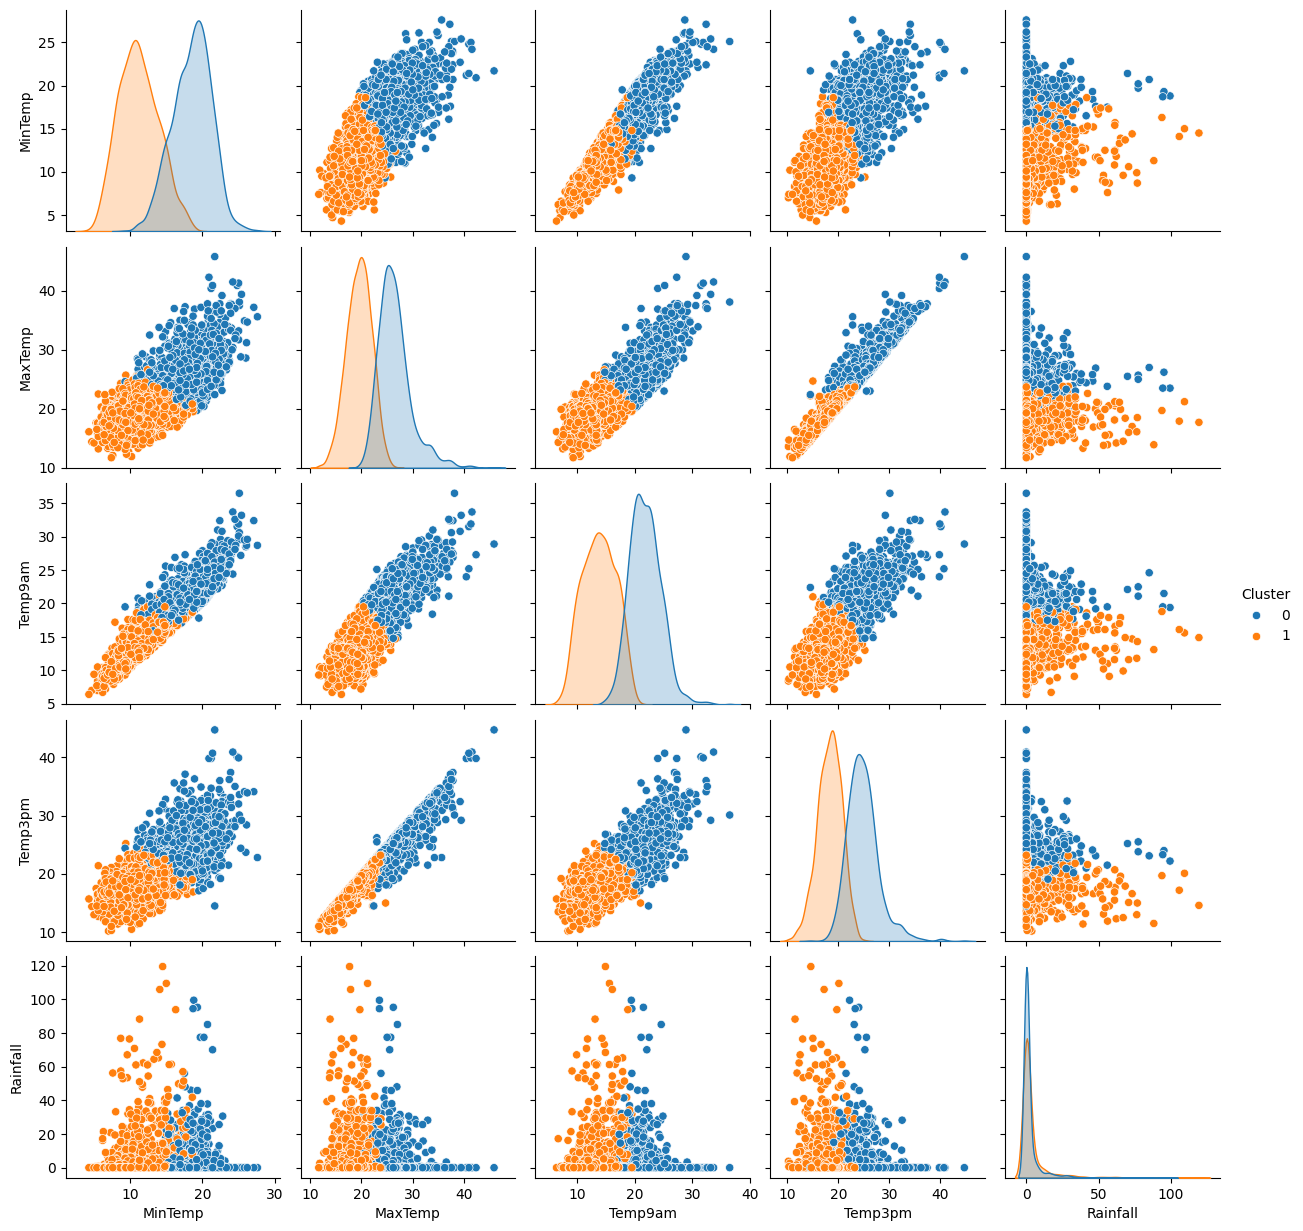

RainTomorrow    No  Yes
Cluster                
0             1283  397
1             1189  468


In [ ]:
# Entrenar el modelo de Clustering KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_escalado_numerico)

# Añadir los clusters al DataFrame original
data_city['Cluster'] = clusters

# Visualización de Clusters
sns.pairplot(data_city, hue='Cluster', diag_kind='kde')
plt.show()

# Analizar la distribución de clusters con respecto a la variable objetivo
cluster_analysis = pd.crosstab(data_city['Cluster'], data_city['RainTomorrow'])
print(cluster_analysis)


#**Conclusiones:**

En este proyecto, hemos comparado diferentes modelos para predecir la probabilidad de lluvia al día siguiente utilizando datos climáticos de Sydney. Los modelos comparados incluyen Naive Bayes, Regresión Logística, Árbol de Decisión, y KMeans. A continuación, se resumen los resultados y las conclusiones:

* Modelo Naive Bayes:

Precisión: 0.76
Interpretación: Este modelo es simple y eficaz para problemas de clasificación con variables independientes. Sin embargo, la precisión de 0.76 sugiere que podría no capturar todas las complejidades de los datos climáticos.

* Modelo de Regresión Logística:

Precisión: 0.79
Interpretación: Este modelo es adecuado para problemas de clasificación binaria y proporciona una buena interpretación de los coeficientes de las características. La precisión de 0.79 indica que es un modelo razonablemente bueno para predecir la probabilidad de lluvia.

* Modelo de Árbol de Decisión:

Precisión: 0.70
Interpretación: Este modelo es fácil de interpretar y puede capturar relaciones no lineales en los datos. Sin embargo, con una precisión de 0.70, es el menos preciso de los modelos comparados en este proyecto.

* Modelo de Clustering KMeans:

El modelo KMeans nos permitió identificar patrones en los datos climáticos, agrupando los datos en clusters. La visualización de los clusters mostró diferencias significativas en la distribución de la variable objetivo (lluvia mañana) entre los clusters, proporcionando insights sobre cómo diferentes condiciones climáticas pueden agruparse y cómo estas agrupaciones se relacionan con la ocurrencia de lluvia.


###**Recomendaciones**

*Basándonos en los resultados obtenidos, el modelo de Regresión Logística se destaca como el más preciso para predecir la probabilidad de lluvia al día siguiente en Sydney, con una precisión de 0.79.*

Sin embargo, cada modelo tiene sus propias ventajas y desventajas:

* Naive Bayes es rápido y eficiente, pero puede ser demasiado simple para capturar todas las complejidades de los datos climáticos.
* Regresión Logística proporciona interpretabilidad y una alta precisión, lo que lo hace adecuado para aplicaciones donde se necesita entender la contribución de cada variable.
* Árbol de Decisión es interpretativo y puede manejar relaciones no lineales, pero es susceptible al sobreajuste y tiene la menor precisión de los modelos comparados.
* KMeans es útil para identificar patrones y segmentar los datos climáticos, proporcionando insights adicionales que pueden complementar los modelos supervisados.


###**Relevancia para la Toma de Decisiones Climáticas**

La capacidad de predecir la probabilidad de lluvia al día siguiente es crucial para una variedad de aplicaciones prácticas que impactan la vida diaria y las operaciones comerciales. Estas predicciones pueden ayudar en la planificación de actividades agrícolas, la gestión de eventos al aire libre, la logística y el transporte, y en la preparación para emergencias climáticas.

###**Insights de Alto Impacto**

**Sistema de Alerta Temprana:** Implementar un sistema de alerta temprana basado en predicciones meteorológicas puede reducir los incidentes de seguridad y mejorar la planificación de actividades.
* Optimización de Recursos: Con predicciones precisas, se pueden optimizar recursos en sectores como la agricultura, reduciendo el desperdicio de agua y mejorando la productividad.
* Mejora de la Seguridad: Identificar condiciones climáticas adversas y tomar medidas preventivas puede mejorar la seguridad de las personas y los negocios, reduciendo interrupciones y daños.


En resumen, el análisis y modelado de los datos climáticos no solo permiten predecir condiciones meteorológicas, sino que también proporcionan una base sólida para la toma de decisiones informadas en múltiples sectores. Las futuras mejoras podrían incluir el uso de técnicas de selección de características, modelos más avanzados y una validación cruzada más robusta para aumentar la precisión y utilidad de los modelos.

# EXAMEN

# Predicción de la Probabilidad de Lluvia en Sydney

## Introducción
El objetivo de este proyecto es predecir la probabilidad de lluvia al día siguiente en Sydney utilizando datos meteorológicos históricos. Esta predicción es crucial para diversas actividades como la agricultura, la planificación de eventos al aire libre y la preparación para emergencias climáticas.

## Propósito y Justificación
Predecir la lluvia ayuda a tomar decisiones informadas y planificar actividades de manera más efectiva. Utilizando datos meteorológicos históricos, podemos identificar patrones que nos permitan anticipar eventos climáticos, mejorando así la eficiencia y la seguridad en diversas industrias.

## Contexto del Proyecto
Sydney es una ciudad con un clima variado que puede impactar significativamente en diferentes sectores económicos y sociales. La predicción precisa de la lluvia puede ayudar a mitigar riesgos y optimizar la planificación de actividades, mejorando la calidad de vida de sus habitantes y la eficiencia de las operaciones comerciales.

## Objetivos del Proyecto
1. **Predecir la Probabilidad de Lluvia al Día Siguiente**: Utilizar modelos de aprendizaje automático para predecir si lloverá o no al día siguiente en Sydney.
2. **Identificar Variables Significativas**: Determinar cuáles variables climáticas tienen el mayor impacto en la predicción de la lluvia.
3. **Evaluar el Rendimiento del Modelo**: Medir la precisión del modelo y evaluar su capacidad para generalizar a datos no vistos.
4. **Generar Información Útil**: Proporcionar insights que puedan ser utilizados para la toma de decisiones en diversas industrias.

## Selección de Variables
Para lograr nuestros objetivos, hemos seleccionado las siguientes variables del conjunto de datos:

### 1. **MaxTemp (Temperatura Máxima):**

La temperatura máxima del día influye en el ciclo del agua en la atmósfera. Temperaturas más altas aumentan la evaporación del agua de la superficie terrestre (mares, ríos, lagos, etc.), incrementando la cantidad de vapor de agua en la atmósfera. Este vapor puede condensarse para formar nubes y eventualmente precipitar como lluvia.

Asociación con la lluvia: Altas temperaturas suelen estar asociadas con una mayor humedad relativa, que es un precursor de la formación de nubes y lluvia, especialmente en climas cálidos.

### 2. **Humidity9am (Humedad a las 9 AM):**

La humedad a las 9 AM puede dar una buena idea del contenido de vapor de agua en la atmósfera a primera hora del día. Una humedad alta a esta hora puede indicar una alta disponibilidad de vapor de agua, que puede condensarse en forma de nubes y eventualmente precipitar.

Asociación con la lluvia: Una alta humedad relativa es esencial para la formación de nubes y la precipitación. Si la atmósfera está saturada de humedad a primera hora del día, la probabilidad de lluvia más tarde es alta.
### 3. **Pressure9am (Presión a las 9 AM):**

La presión atmosférica es un indicador clave de las condiciones meteorológicas. Bajas presiones están asociadas con sistemas de baja presión que suelen traer consigo condiciones de mal tiempo, incluyendo lluvia.

Asociación con la lluvia: La presión baja indica una mayor probabilidad de condiciones inestables y ascendentes en la atmósfera, lo que favorece la formación de nubes y precipitación.
### 4. **Rainfall (Cantidad de Lluvia Registrada):**

La cantidad de lluvia que ya ha caído es un indicador directo de las condiciones meteorológicas recientes. Si ha llovido recientemente, la atmósfera puede estar saturada de humedad, lo que aumenta la probabilidad de lluvia continua o adicional.

Asociación con la lluvia: Precipitaciones recientes pueden indicar una atmósfera ya inestable y húmeda, condiciones que pueden persistir y causar más lluvia.


La selección de estas variables se basa en su relevancia para la formación de lluvias y su capacidad para capturar condiciones atmosféricas clave que influyen en la probabilidad de precipitaciones. La combinación de estas variables proporciona una cobertura integral de las condiciones meteorológicas, mejorando la capacidad predictiva del modelo.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

In [ ]:
# Cargar datos desde Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
drive_content = os.listdir('/content/drive/MyDrive/')
# Cargar los datos
drive_path = '/content/drive/MyDrive/'
# Ruta completa al archivo Excel en Google Drive
file_path = drive_path + 'weatherAUS.csv'

# Cargar el archivo Excel en un DataFrame
data_frame = pd.read_csv(file_path, delimiter=',',decimal='.')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Seleccionar variables relevantes y filtrar datos para la ciudad de Sydney
variables_relevantes = ['MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am', 'RainTomorrow']
data_frame = data_frame.dropna(subset=variables_relevantes)
data_city = data_frame[data_frame['Location'] == 'Sydney'].copy()


In [ ]:
# Convertir 'RainTomorrow' a una variable numérica
data_city['RainTomorrow'] = data_city['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

# Verificar la distribución de clases en el conjunto completo
print("Distribución de clases en el conjunto completo:")
print(data_city['RainTomorrow'].value_counts())

Distribución de clases en el conjunto completo:
RainTomorrow
0    2441
1     858
Name: count, dtype: int64


In [ ]:
# Información general del conjunto de datos
data_city.info()

# Descripción estadística de las variables numéricas
data_city.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 3299 entries, 29497 to 32833
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3299 non-null   object 
 1   Location       3299 non-null   object 
 2   MinTemp        3297 non-null   float64
 3   MaxTemp        3299 non-null   float64
 4   Rainfall       3299 non-null   float64
 5   Evaporation    3248 non-null   float64
 6   Sunshine       3284 non-null   float64
 7   WindGustDir    2276 non-null   object 
 8   WindGustSpeed  2276 non-null   float64
 9   WindDir9am     3245 non-null   object 
 10  WindDir3pm     3268 non-null   object 
 11  WindSpeed9am   3275 non-null   float64
 12  WindSpeed3pm   3276 non-null   float64
 13  Humidity9am    3299 non-null   float64
 14  Humidity3pm    3293 non-null   float64
 15  Pressure9am    3299 non-null   float64
 16  Pressure3pm    3291 non-null   float64
 17  Cloud9am       2740 non-null   float64
 18  Cloud3pm

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM,RainTomorrow
count,3297.000000,3299.000000,3299.000000,3248.000000,3284.000000,2276.000000,3275.000000,3276.000000,3299.000000,3293.000000,3299.000000,3291.000000,2740.000000,2745.000000,3299.000000,3296.000000,3299.000000,3299.000000
mean,14.875827,23.010761,3.348409,5.188608,7.177071,41.731547,15.066870,19.305861,68.234010,54.703917,1018.343589,1016.012790,4.179927,4.212750,17.825826,21.541687,3.339800,0.260079
std,4.557822,4.490771,9.937583,2.783914,3.813250,13.015949,7.069045,7.474936,15.085438,16.298647,7.023652,7.025481,2.749509,2.642702,4.899523,4.301724,9.923588,0.438744
min,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000,6.400000,10.200000,0.000000,0.000000
25%,11.000000,19.600000,0.000000,3.200000,4.300000,31.000000,9.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,1.000000,1.000000,13.800000,18.400000,0.000000,0.000000
50%,14.900000,22.900000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,4.000000,4.000000,18.200000,21.300000,0.000000,0.000000
75%,18.800000,26.000000,1.400000,7.000000,10.200000,50.000000,20.000000,24.000000,80.000000,65.000000,1023.100000,1020.800000,7.000000,7.000000,21.700000,24.500000,1.400000,1.000000
max,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000,36.500000,44.700000,119.400000,1.000000


Identificación de Valores Faltantes y Atípicos

In [ ]:
# Conteo de valores faltantes antes de la limpieza
print("Valores faltantes antes de la limpieza:")
print(data_city.isnull().sum())

Valores faltantes antes de la limpieza:
Date                0
Location            0
MinTemp             2
MaxTemp             0
Rainfall            0
Evaporation        51
Sunshine           15
WindGustDir      1023
WindGustSpeed    1023
WindDir9am         54
WindDir3pm         31
WindSpeed9am       24
WindSpeed3pm       23
Humidity9am         0
Humidity3pm         6
Pressure9am         0
Pressure3pm         8
Cloud9am          559
Cloud3pm          554
Temp9am             0
Temp3pm             3
RainToday           0
RISK_MM             0
RainTomorrow        0
dtype: int64


Limpieza de Valores Nulos

In [ ]:
# Rellenar valores nulos en variables numéricas con la media
numeric_columns = data_city.select_dtypes(include=['float64', 'int64']).columns
data_city[numeric_columns] = data_city[numeric_columns].fillna(data_city[numeric_columns].mean())

# Rellenar valores nulos en variables categóricas con la moda
categorical_columns = data_city.select_dtypes(include=['object']).columns
data_city[categorical_columns] = data_city[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))

# Conteo de valores faltantes después de la limpieza
print("\nValores faltantes después de la limpieza:")
print(data_city.isnull().sum())



Valores faltantes después de la limpieza:
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RISK_MM          0
RainTomorrow     0
dtype: int64


Valores Atípicos (Outliers)

Utilizamos diagramas de caja (boxplots) para identificar valores atípicos en las variables numéricas.

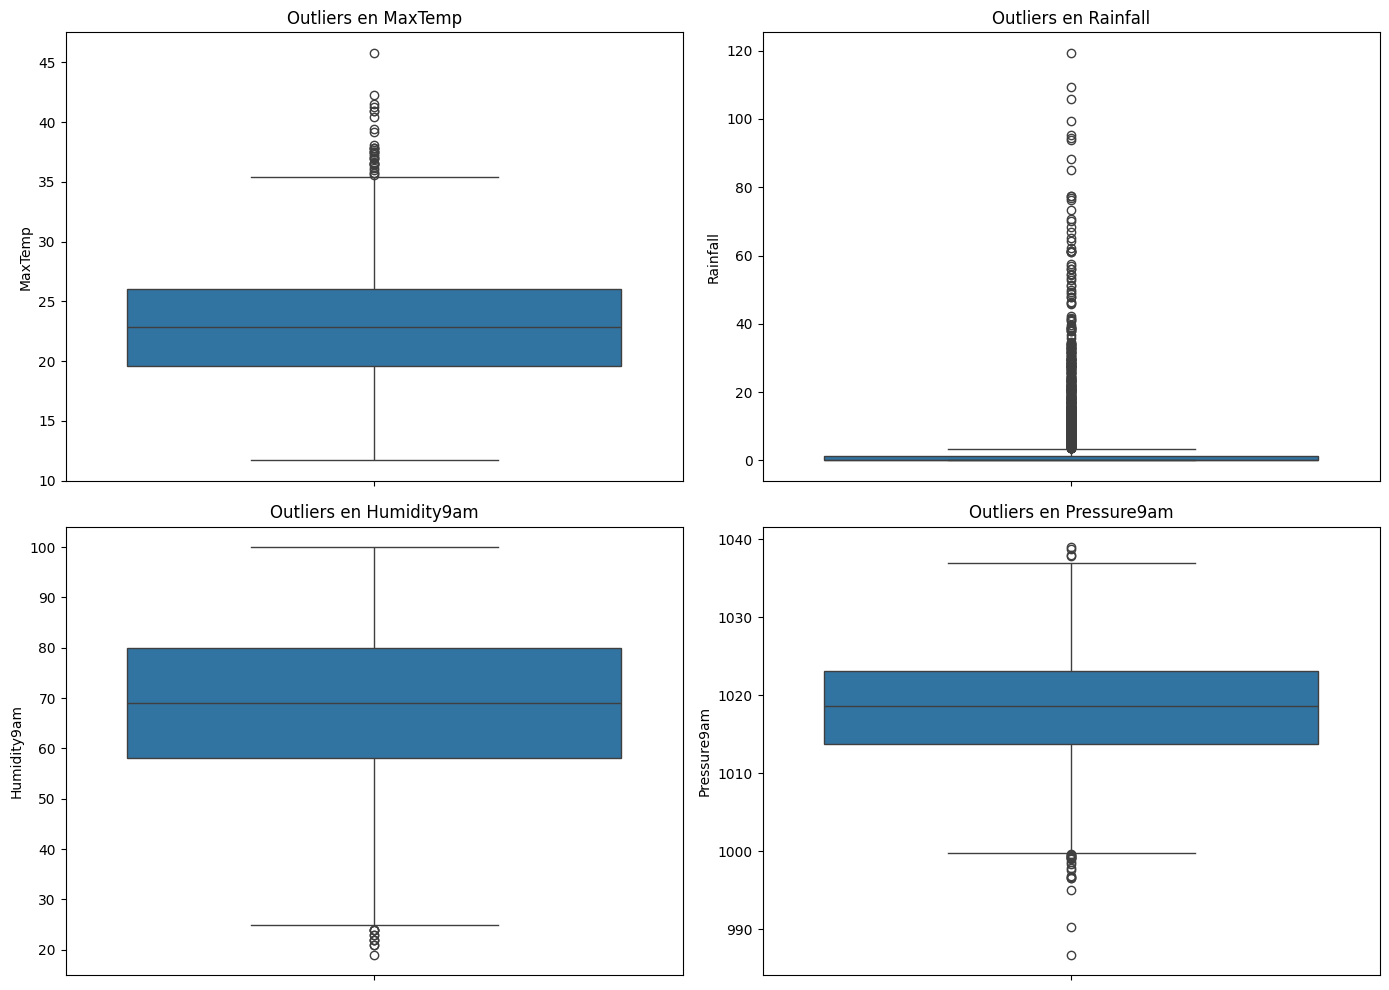

In [ ]:
# Boxplots para identificar outliers
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data_city['MaxTemp'].dropna())
plt.title('Outliers en MaxTemp')

plt.subplot(2, 2, 2)
sns.boxplot(data_city['Rainfall'].dropna())
plt.title('Outliers en Rainfall')

plt.subplot(2, 2, 3)
sns.boxplot(data_city['Humidity9am'].dropna())
plt.title('Outliers en Humidity9am')

plt.subplot(2, 2, 4)
sns.boxplot(data_city['Pressure9am'].dropna())
plt.title('Outliers en Pressure9am')

plt.tight_layout()
plt.show()


Cálculo de Estadísticos Descriptivos, Valores Faltantes y Outliers

In [ ]:
# Cálculo de estadísticos descriptivos para variables numéricas
variables_numericas = ['MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am']
estadisticos_descriptivos = data_city[variables_numericas].describe().transpose()
estadisticos_descriptivos['median'] = data_city[variables_numericas].median()
estadisticos_descriptivos['Q1'] = data_city[variables_numericas].quantile(0.25)
estadisticos_descriptivos['Q3'] = data_city[variables_numericas].quantile(0.75)
estadisticos_descriptivos = estadisticos_descriptivos[['mean', 'median', 'std', 'min', 'max', 'Q1', 'Q3']]

print("Estadísticos descriptivos para las variables clave:")
print(estadisticos_descriptivos)


Estadísticos descriptivos para las variables clave:
                    mean  median        std    min     max      Q1      Q3
MaxTemp        23.010761    22.9   4.490771   11.7    45.8    19.6    26.0
Rainfall        3.348409     0.0   9.937583    0.0   119.4     0.0     1.4
Humidity9am    68.234010    69.0  15.085438   19.0   100.0    58.0    80.0
Pressure9am  1018.343589  1018.6   7.023652  986.7  1039.0  1013.7  1023.1


Análisis de Correlación
Primero, es útil entender cómo se relacionan las variables entre sí. Esto se puede hacer mediante el cálculo de la matriz de correlación y la visualización con un mapa de calor.

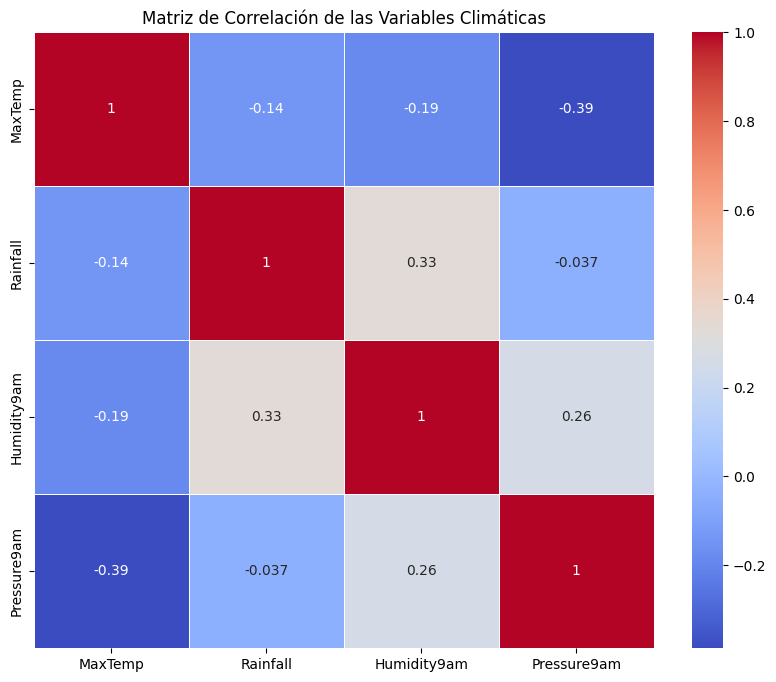

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = data_city[variables_interes].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de las Variables Climáticas')
plt.show()


Relación entre Variables Climáticas y la Lluvia
Para comprender mejor cómo las variables climáticas afectan la probabilidad de lluvia, podemos usar gráficos de pares (pair plots) que muestren las relaciones entre las variables numéricas y la variable objetivo 'RainTomorrow'.

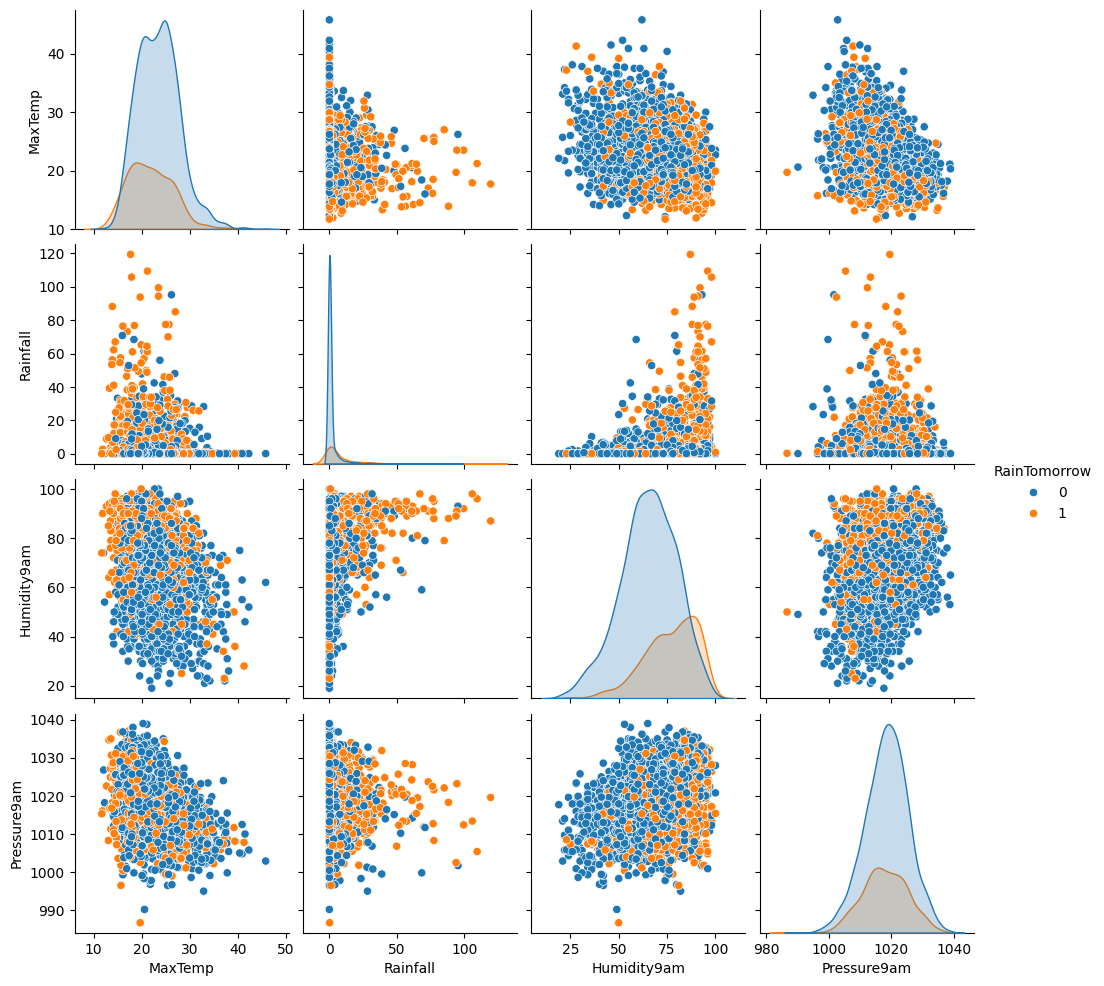

In [ ]:
# Visualizar las relaciones entre variables numéricas y la variable objetivo
sns.pairplot(data_city, hue='RainTomorrow', vars=['MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am'])
plt.show()


# Etapa de Modelado

In [ ]:
# Variables numéricas disponibles en el DataFrame
columnas_numericas = ['MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am']

# Escalar características numéricas
scaler = StandardScaler()
X_escalado_numerico = scaler.fit_transform(data_city[columnas_numericas])

# La variable objetivo para predecir la lluvia mañana
y = data_city['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

# Imputar valores faltantes y escalar características antes de la división
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X = data_city[variables_relevantes[:-1]]
y = data_city['RainTomorrow']

X = imputer.fit_transform(X)
X = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modelos Supervisados

# Modelo de Regresión Logística

In [ ]:
# Entrenar el modelo de Regresión Logística
model_lr = LogisticRegression(max_iter=200)
model_lr.fit(X_train, y_train)

# Predicciones y evaluación del modelo de Regresión Logística
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Precisión del modelo de Regresión Logística: {accuracy_lr:.2f}')
print(classification_report(y_test, y_pred_lr))

Precisión del modelo de Regresión Logística: 0.78
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       488
           1       0.64      0.34      0.44       172

    accuracy                           0.78       660
   macro avg       0.72      0.63      0.65       660
weighted avg       0.76      0.78      0.75       660



EVALUACION DE MODELO

Precisión del modelo de Regresión Logística en el conjunto de entrenamiento: 0.79
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1953
           1       0.70      0.32      0.44       686

    accuracy                           0.79      2639
   macro avg       0.75      0.63      0.65      2639
weighted avg       0.77      0.79      0.76      2639

Precisión del modelo de Regresión Logística en el conjunto de prueba: 0.78
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       488
           1       0.64      0.34      0.44       172

    accuracy                           0.78       660
   macro avg       0.72      0.63      0.65       660
weighted avg       0.76      0.78      0.75       660



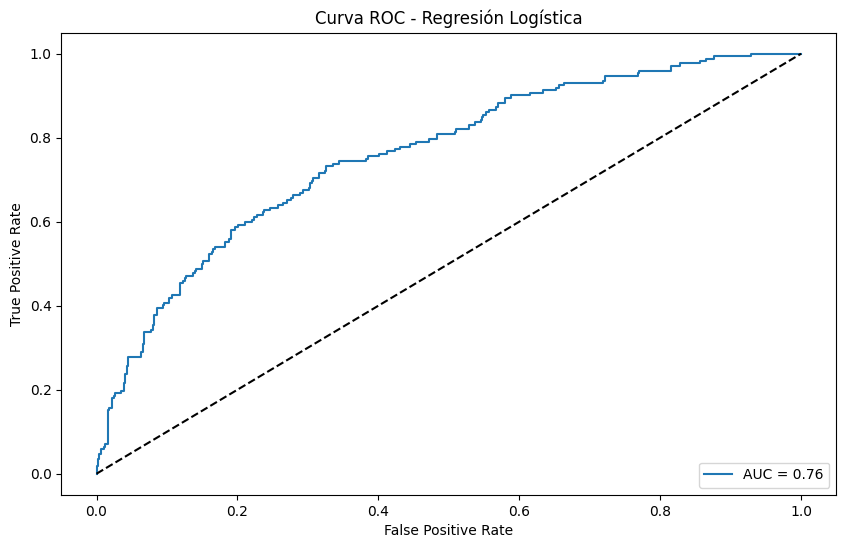

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train_lr = model_lr.predict(X_train)
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
print(f'Precisión del modelo de Regresión Logística en el conjunto de entrenamiento: {accuracy_train_lr:.2f}')
print(classification_report(y_train, y_pred_train_lr))

# Evaluar el modelo en el conjunto de prueba
y_pred_test_lr = model_lr.predict(X_test)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)
print(f'Precisión del modelo de Regresión Logística en el conjunto de prueba: {accuracy_test_lr:.2f}')
print(classification_report(y_test, y_pred_test_lr))

# Generar las probabilidades de predicción
y_prob_lr = model_lr.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)

# Calcular AUC
auc = roc_auc_score(y_test, y_prob_lr)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

La curva ROC (Receiver Operating Characteristic) muestra la tasa de verdaderos positivos contra la tasa de falsos positivos. La curva tiene una forma ascendente, lo que indica que el modelo es mejor que uno aleatorio.

AUC (Área Bajo la Curva): El AUC es de 0.76, lo que indica que el modelo tiene un rendimiento aceptable. Un AUC de 1.0 sería perfecto, mientras que un AUC de 0.5 indica que el modelo no es mejor que el azar.

Interpretación

* Clase Desbalanceada: El recall bajo para la clase 'Sí' sugiere que el modelo tiene dificultades para identificar instancias de lluvia. Esto puede ser un signo de desbalance de clases, donde hay muchas más instancias de 'No lluvia' que de 'Lluvia'.
* Precisión General: La precisión del modelo es razonablemente alta, pero la baja recall para la clase 'Sí' indica que el modelo necesita mejorar en la detección de días de lluvia.
* Generalización: La consistencia entre las métricas de entrenamiento y prueba sugiere que el modelo generaliza bien y no está sobreajustado.

# Modelo Naive Bayes



In [ ]:
# Entrenar el modelo Naive Bayes
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

# Predicciones y evaluación del modelo Naive Bayes
y_pred_nb = model_nb.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f'Precisión del modelo Naive Bayes: {accuracy_nb:.2f}')
print(classification_report(y_test, y_pred_nb))


Precisión del modelo Naive Bayes: 0.77
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       488
           1       0.65      0.27      0.39       172

    accuracy                           0.77       660
   macro avg       0.72      0.61      0.62       660
weighted avg       0.75      0.77      0.74       660



EVALUACION DE MODELO

Precisión del modelo Naive Bayes en el conjunto de entrenamiento: 0.78
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      1953
           1       0.70      0.25      0.37       686

    accuracy                           0.78      2639
   macro avg       0.74      0.61      0.62      2639
weighted avg       0.76      0.78      0.74      2639

Precisión del modelo Naive Bayes en el conjunto de prueba: 0.77
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       488
           1       0.65      0.27      0.39       172

    accuracy                           0.77       660
   macro avg       0.72      0.61      0.62       660
weighted avg       0.75      0.77      0.74       660



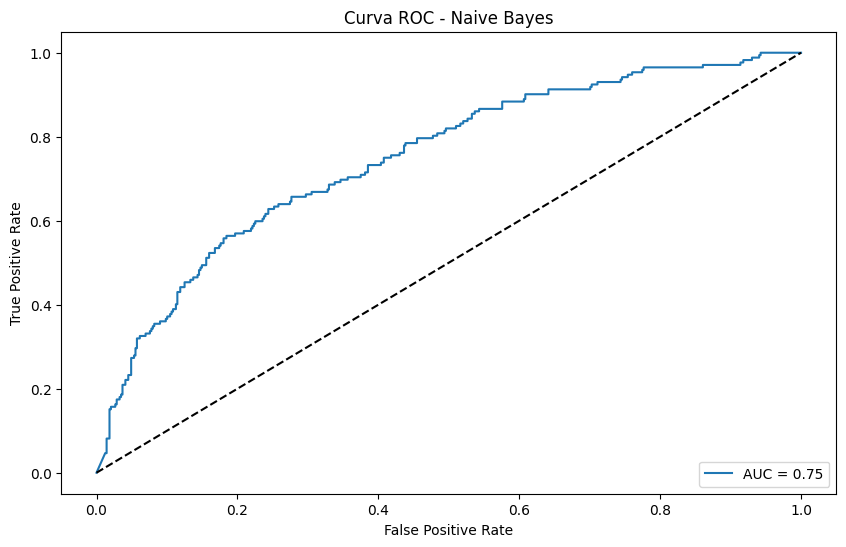

In [ ]:
# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train_nb = model_nb.predict(X_train)
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
print(f'Precisión del modelo Naive Bayes en el conjunto de entrenamiento: {accuracy_train_nb:.2f}')
print(classification_report(y_train, y_pred_train_nb))

# Evaluar el modelo en el conjunto de prueba
y_pred_test_nb = model_nb.predict(X_test)
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)
print(f'Precisión del modelo Naive Bayes en el conjunto de prueba: {accuracy_test_nb:.2f}')
print(classification_report(y_test, y_pred_test_nb))

# Generar las probabilidades de predicción para el conjunto de prueba
y_prob_nb = model_nb.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y umbrales
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_prob_nb)

# Calcular AUC
auc_nb = roc_auc_score(y_test, y_prob_nb)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_nb, tpr_nb, label=f'AUC = {auc_nb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Naive Bayes')
plt.legend(loc='lower right')
plt.show()

La curva ROC muestra la tasa de verdaderos positivos contra la tasa de falsos positivos. La curva tiene una forma ascendente, lo que indica que el modelo es mejor que uno aleatorio.

AUC (Área Bajo la Curva): El AUC es de 0.75, lo que indica que el modelo tiene un rendimiento aceptable. Un AUC de 1.0 sería perfecto, mientras que un AUC de 0.5 indica que el modelo no es mejor que el azar.

Interpretación

* Clase Desbalanceada: Al igual que en el modelo de regresión logística, el recall bajo para la clase 'Sí' sugiere que el modelo tiene dificultades para identificar instancias de lluvia. Esto nuevamente puede ser un signo de desbalance de clases.
* Precisión General: La precisión del modelo es razonablemente alta, pero la baja recall para la clase 'Sí' indica que el modelo necesita mejorar en la detección de días de lluvia.
* Generalización: La consistencia entre las métricas de entrenamiento y prueba sugiere que el modelo generaliza bien y no está sobreajustado.

Modelo de Árbol de Decisión

In [ ]:
# Entrenar el modelo de Árbol de Decisión
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)

# Predicciones y evaluación del modelo de Árbol de Decisión
y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Precisión del modelo de Árbol de Decisión: {accuracy_dt:.2f}')
print(classification_report(y_test, y_pred_dt))


Precisión del modelo de Árbol de Decisión: 0.68
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       488
           1       0.39      0.42      0.40       172

    accuracy                           0.68       660
   macro avg       0.59      0.59      0.59       660
weighted avg       0.68      0.68      0.68       660



EVALUACION DE MODELO

Precisión del modelo de Árbol de Decisión en el conjunto de entrenamiento: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1953
           1       1.00      1.00      1.00       686

    accuracy                           1.00      2639
   macro avg       1.00      1.00      1.00      2639
weighted avg       1.00      1.00      1.00      2639

Precisión del modelo de Árbol de Decisión en el conjunto de prueba: 0.68
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       488
           1       0.39      0.42      0.40       172

    accuracy                           0.68       660
   macro avg       0.59      0.59      0.59       660
weighted avg       0.68      0.68      0.68       660



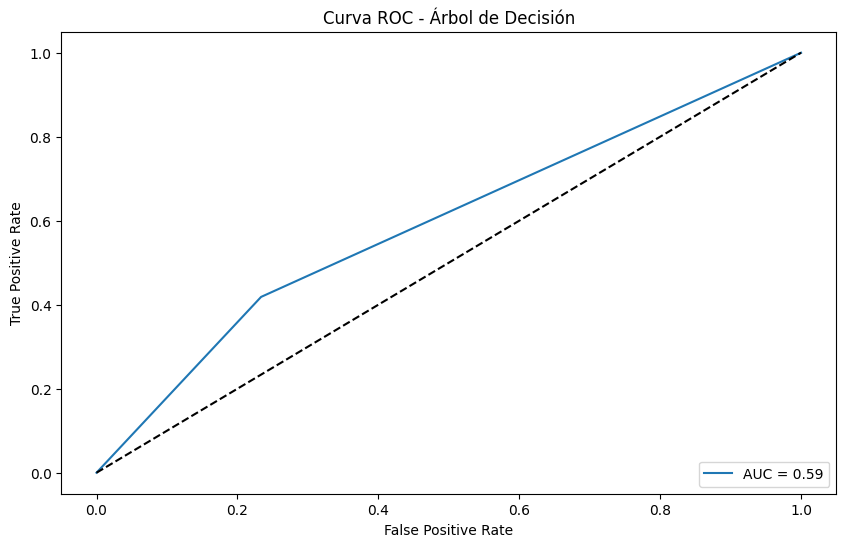

In [ ]:
# Evaluar el modelo en el conjunto de entrenamiento
y_pred_train_dt = model_dt.predict(X_train)
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
print(f'Precisión del modelo de Árbol de Decisión en el conjunto de entrenamiento: {accuracy_train_dt:.2f}')
print(classification_report(y_train, y_pred_train_dt))

# Evaluar el modelo en el conjunto de prueba
y_pred_test_dt = model_dt.predict(X_test)
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)
print(f'Precisión del modelo de Árbol de Decisión en el conjunto de prueba: {accuracy_test_dt:.2f}')
print(classification_report(y_test, y_pred_test_dt))

# Generar las probabilidades de predicción para el conjunto de prueba
y_prob_dt = model_dt.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y umbrales
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_prob_dt)

# Calcular AUC
auc_dt = roc_auc_score(y_test, y_prob_dt)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'AUC = {auc_dt:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc='lower right')
plt.show()

La curva ROC del modelo de Árbol de Decisión es bastante plana, lo que indica un rendimiento relativamente pobre en comparación con un modelo ideal.

AUC (Área Bajo la Curva):  El AUC es de 0.59, lo que sugiere que el modelo apenas es mejor que el azar. Esto refuerza la evidencia de que el modelo no generaliza bien fuera del conjunto de entrenamiento.

Interpretación

* Sobreajuste (Overfitting): El modelo de Árbol de Decisión muestra claros signos de sobreajuste, con una precisión perfecta en el conjunto de entrenamiento y un rendimiento mucho peor en el conjunto de prueba. Esto es indicativo de que el modelo ha aprendido demasiado bien los detalles y el ruido del conjunto de entrenamiento y no generaliza bien a datos nuevos.
* Desempeño en la Clase Minoritaria: El modelo tiene un rendimiento especialmente pobre en la predicción de la clase 'Sí' (1), con una baja precisión y recall en el conjunto de prueba. Esto sugiere que el modelo no está manejando bien el desbalance de clases.
* Generalización: La gran diferencia en el rendimiento entre los conjuntos de entrenamiento y prueba indica que el modelo necesita ajustes para mejorar su capacidad de generalización. Podrían considerarse técnicas como la poda del árbol, el uso de un criterio de división diferente o la implementación de un ensamble de árboles (como Random Forest) para mejorar el rendimiento.

# Modelos No Supervisados
Modelo de Clustering KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


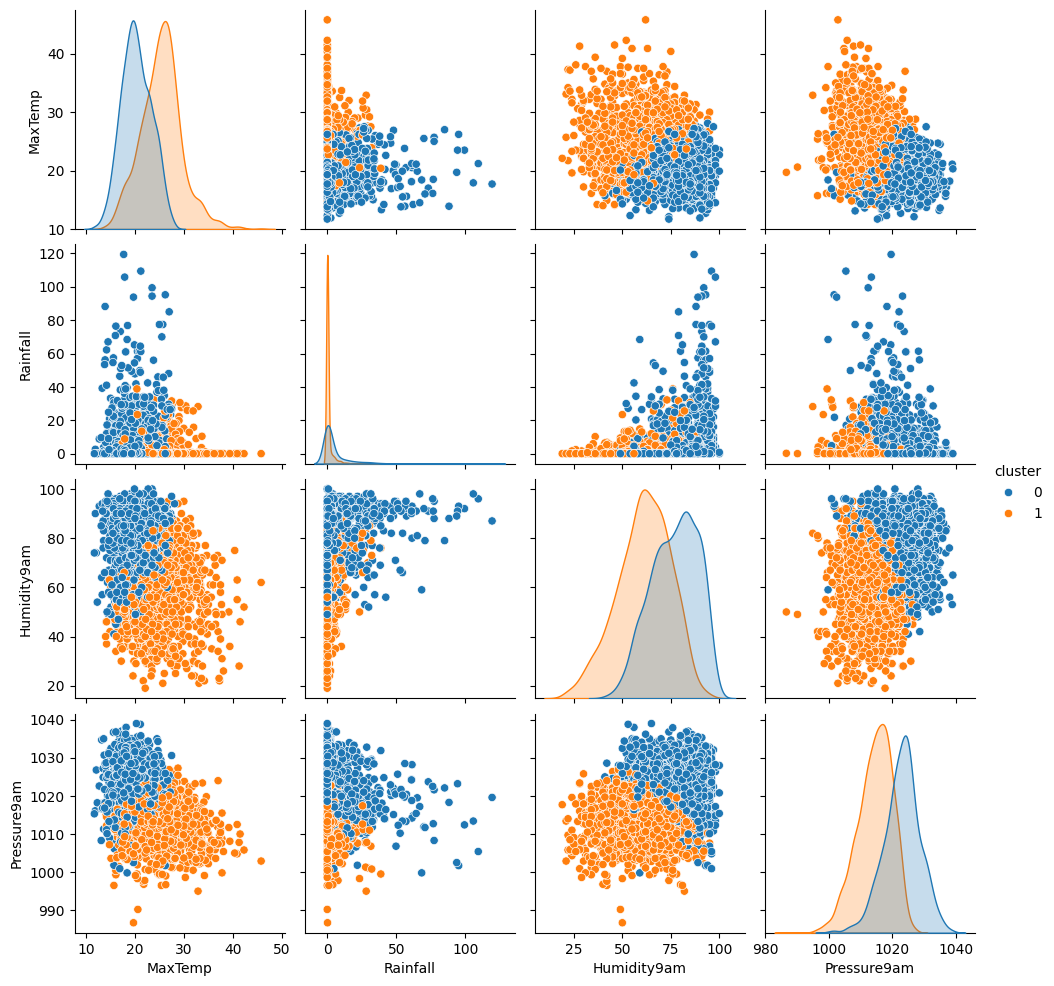

RainTomorrow     0    1
cluster                
0              989  535
1             1452  323


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_escalado_numerico)

# Añadir los clusters al DataFrame original
data_city['cluster'] = clusters

# Visualización de Clusters para las variables seleccionadas
variables_seleccionadas = ['MaxTemp', 'Rainfall', 'Humidity9am', 'Pressure9am', 'cluster']
sns.pairplot(data_city[variables_seleccionadas], hue='cluster', diag_kind='kde')
plt.show()

# Analizar la distribución de clusters con respecto a la variable objetivo
cluster_analysis = pd.crosstab(data_city['cluster'], data_city['RainTomorrow'])
print(cluster_analysis)

# **CONCLUSIONES:**

## **Precisión v/s Sensibilidad**

Aunque los modelos de Regresión Logística y Naive Bayes alcanzaron precisiones razonables (0.78 y 0.77 respectivamente), su sensibilidad para la clase 'Sí' (días de lluvia) fue baja (0.34 y 0.27). Esto sugiere que estos modelos son buenos para predecir días sin lluvia, pero no son confiables para predecir días lluviosos. La precisión general es buena, pero para aplicaciones donde predecir la lluvia es crucial, estos modelos necesitan mejoras.

## **Problema de clase desbalanceada**

Los tres modelos (Regresión Logística, Naive Bayes y Árbol de Decisión) muestran una tendencia a subestimar la ocurrencia de lluvia. Esto es evidente por el bajo recall y F1-Score para la clase 'Sí', y por el alto número de falsos negativos. Abordar el desbalance de clases en los datos es esencial para mejorar la predicción de días lluviosos.

## **Rendimiento del árbol de decisión**

El modelo de Árbol de Decisión mostró un claro sobreajuste con una precisión de entrenamiento muy alta pero una precisión de prueba baja (0.68). Este modelo no generaliza bien y tiene un rendimiento pobre en comparación con los otros modelos. Técnicas como la poda del árbol o el uso de un ensamble de árboles podrían mejorar su desempeño.

## **Curvas ROC y AUC**

Las curvas ROC y los valores de AUC para los modelos de Regresión Logística (0.76) y Naive Bayes (0.75) son aceptables, sugiriendo que estos modelos son moderadamente buenos en la clasificación general. Sin embargo, el AUC del Árbol de Decisión (0.59) indica que su rendimiento es apenas mejor que el azar, reforzando la necesidad de mejoras significativas.






## **Insights de alto impacto**

* *Agricultura:* Dado que la capacidad de predecir días lluviosos es crítica para la planificación agrícola, los modelos actuales pueden llevar a decisiones subóptimas, como la siembra y cosecha en días lluviosos no previstos. Mejorar la predicción de la lluvia puede optimizar la productividad agrícola y reducir pérdidas.

* *Planificación de Eventos:* La baja sensibilidad para predecir lluvia significa que eventos al aire libre pueden verse afectadas por lluvias imprevistas, lo que puede causar cancelaciones y pérdidas económicas. Un modelo mejorado ayudaría a una mejor planificación y mitigación de riesgos.

* *Preparación para Emergencias:* En contextos de manejo de desastres y emergencias climáticas, la capacidad de predecir con precisión días lluviosos es esencial para la preparación y respuesta. Los actuales modelos necesitan ser mejorados para ser útiles en estos escenarios.


En resumen, el análisis y modelado de datos climáticos no solo permiten predecir condiciones meteorológicas, sino que también ofrecen una base sólida para la toma de decisiones informadas en diversos sectores. Para mejorar la precisión y utilidad de estos modelos en el futuro, sería beneficioso incorporar técnicas de selección de características, emplear modelos más avanzados y realizar una validación cruzada más robusta.